In [8]:
# Import packages
# from preprocessing.filtering import Preprocess
# from preprocessing.fiducials import FpCollection
# from preprocessing import PPG

# from preprocessing import Fiducials, Biomarkers
# import pyPPG.biomarkers as BM

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# from pathlib import Path
# from dotmap import DotMap
# import numpy as np
# import pandas as pd
# import scipy.io
# import random
# import os
# import h5py



In [9]:
# Import packages
from utils.dataloaders import Crops
from utils import random_state
import random

random_state(36)

In [10]:
# dataset
crops_data = Crops()
crops_data.split(test_size=0.15)

# test_set = CropsDataset(crops_data.test, mode=mode, stratify=False)
# val_set = CropsDataset(crops_data.val, mode=mode, stratify=True)
# train_set = CropsDataset(crops_data.train, mode=mode, stratify=True)

loading N_crops.h5...
loading V_crops.h5...
loading S_crops.h5...


In [11]:
# Parameters
stratify = True

# Stratify
V = []
S = []
N = []
for x, y in crops_data.train:
    if y == "V" :
        V.append(x)
    elif y == "S":
        S.append(x)
    else:
        N.append(x)

n_smallest_class = min(len(V), len(S))
dataset = {label: crops for label, crops in zip(['N', 'V', 'S'], [N, V, S])}

# Stratify the dataset
if stratify:
    random.seed(36)
    for label, crops in dataset.items():
        if len(crops) > n_smallest_class:
            random.shuffle(crops)
            if label == 'N':
                dataset[label] = crops[0:2*n_smallest_class]

            elif label in ['V', 'S']:
                dataset[label] = crops[0:n_smallest_class]

for label, crops in dataset.items():
    print(f'{label}: {len(crops)}')

print(f'Total number of crops for training: {sum([len(crops) for crops in dataset.values()])} / {4*n_smallest_class}')

N: 11192
V: 5596
S: 5596
Total number of crops for training: 22384 / 22384


In [13]:
# Parameters
stratify = True

data = {}
for split_name, split_data in zip(["train", "val", "test"], [crops_data.train, crops_data.val, crops_data.test]):

    # Stratify
    V = []
    S = []
    N = []
    for crop, label in split_data:
        if label == "V" :
            V.append(crop)
        elif label == "S":
            S.append(crop)
        else:
            N.append(crop)

    n_smallest_class = min(len(V), len(S))
    dataset = {label: crops for label, crops in zip(['N', 'V', 'S'], [N, V, S])}
    
    # Stratify the dataset
    if split_name in ["train", "val"]:
        if stratify:
            random.seed(36)
            for label, crops in dataset.items():
                if len(crops) > n_smallest_class:
                    random.shuffle(crops)
                    if label == 'N':
                        dataset[label] = crops[0:2*n_smallest_class]

                    elif label in ['V', 'S']:
                        dataset[label] = crops[0:n_smallest_class]

    data[split_name] = dataset

    print(f'{split_name} dataset:')
    for label, crops in dataset.items():
        print(f'{label}: {len(crops)}')
    print('-'*20)



print(f'Total number of crops for training: {sum([len(crops) for crops in data["train"].values()])}')

train dataset:
N: 11192
V: 5596
S: 5596
--------------------
val dataset:
N: 2398
V: 1199
S: 1199
--------------------
test dataset:
N: 34056
V: 1199
S: 1454
--------------------
Total number of crops for training: 22384


In [20]:
len(data['train']['N'])

data_train_N = data['train']['N']
data_train_V = data['train']['V']
data_train_S = data['train']['S']


In [38]:
import matplotlib.pyplot as plt
import numpy as np

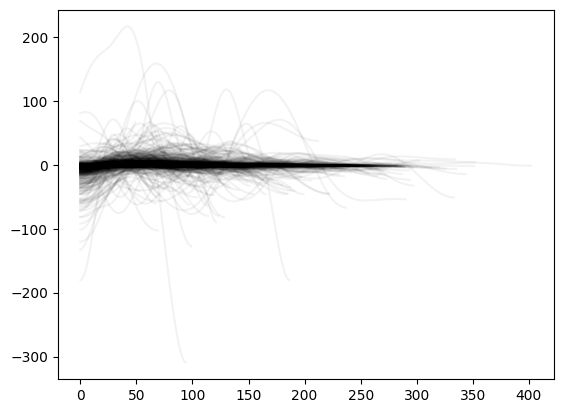

In [69]:
for i in range(2000):
    plt.plot(data_train_N[i], 'k', alpha=0.05)

plt.show()

In [84]:
max_len = np.max([len(crop) for crop in data_train_N])
n = len(data_train_N)
max_ampl = [np.max(np.abs(crop)) for crop in data_train_N]

avg = np.zeros(max_len)

for crop, maxim in zip(data_train_N, max_ampl):
    n_crop = len(crop)
    avg[:n_crop] += crop/n/maxim

[2.48902111316178, 1.451704468540125, 10.649995744469201, 5.522090300247864, 1.5986417839541427, 31.405447965202654, 1.489827864976082, 3.337145510885903, 9.967122796832838, 2.2120107592228337, 1.6400924259481964, 1.3960363020578963, 7.143225373474209, 2.1653387271656466, 1.785944243989644, 2.695403248072107, 309.3135701596611, 2.885224554236676, 2.8377630387402206, 17.270373505257545, 1.3934993706832275, 1.6087857870053903, 1.5514468215618293, 1.8846022893420236, 2.296208440606596, 1.3813002943892208, 1.2822831585757193, 1.1943002581602629, 1.2721544762963557, 33.81278230145261, 2.7870924182972567, 4.418304668816424, 33.5031019419854, 11.163642073387454, 1.8159170471273143, 10.306360458682507, 1.6305122344319631, 1.5586758131165062, 3.6427460628405908, 7.525139643010169, 1.5740999863723442, 34.73318147049762, 1.3826503158825894, 1.9034355172177653, 2.0333651731115316, 1.893936682861273, 26.3061891371095, 1.8200881981474561, 10.486959442863828, 31.63903685684559, 1.305019489645004, 1.6

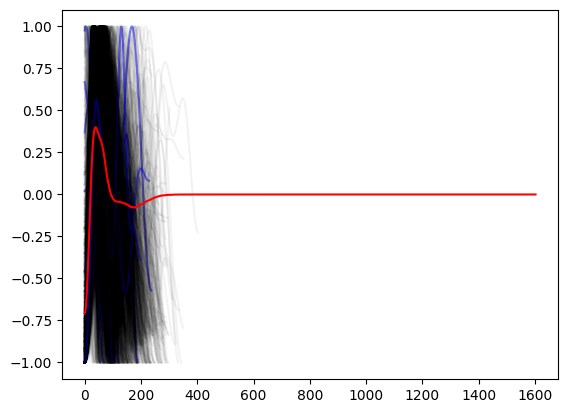

In [85]:
# a = np.array(data_train_S)
max_ampl = [np.max(np.abs(crop)) for crop in data_train_N]

print(max_ampl)

for i in range(2000):
    if max_ampl[i] < 80:
        plt.plot(data_train_N[i]/max_ampl[i], 'k', alpha=0.05)
    else:
        plt.plot(data_train_N[i]/max_ampl[i], 'b', alpha=0.5)

plt.plot(avg, 'r')

plt.show()

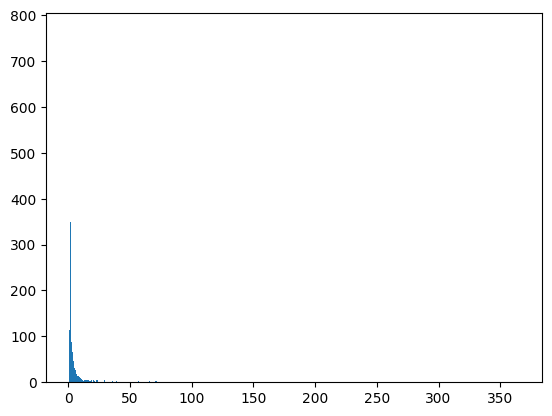

In [73]:
plt.hist(max_ampl, bins=5000)
plt.show()

In [74]:
np.sort(max_ampl)[-50:]

array([102.34743717, 102.63797472, 102.81141199, 103.34591132,
       103.69151294, 103.97706812, 105.70407936, 106.09159814,
       107.26055976, 107.30456651, 108.68395262, 108.89139092,
       109.0783508 , 109.44497657, 110.98151855, 112.11982246,
       112.2554802 , 112.71066682, 113.14261824, 113.15920795,
       113.33930116, 113.5771613 , 116.81251698, 118.17286533,
       120.47718644, 123.09880977, 123.77048933, 125.52272195,
       126.61319743, 127.79882084, 128.78453934, 133.27891525,
       135.25491667, 135.31293456, 137.11729672, 140.38259613,
       142.02117423, 143.4457845 , 147.86003081, 155.40646469,
       158.8806672 , 167.97168404, 176.65235693, 179.25136413,
       180.12565472, 180.45407374, 186.96614339, 190.35660609,
       309.31357016, 365.64744718])